In [24]:
import NameIDHelper
from urllib.request import urlopen, Request
import json


url = 'https://prices.runescape.wiki/api/v1/osrs'
# we want the latest data, so lets add that to the url
url += "/timeseries?timestep=1h&id="
# lets add the abyssal whip to the url:
url += str(NameIDHelper.NameToID("Twisted bow"))

headers = {
    # the wiki blocks all common user-agents in order to prevent spam
    # after talking with some of the API maintainers over discord they asked me to include my discord in the user-agent
    'User-Agent': 'DataTimeHelperExample - @Be#9998',
}

In [25]:
req = Request(url, headers=headers)
with urlopen(req) as response:
            latestData = response.read()
data = json.loads(latestData)
print(data)
print(type(data))

{'data': [{'timestamp': 1678273200, 'avgHighPrice': 1366076875, 'avgLowPrice': 1366000000, 'highPriceVolume': 3, 'lowPriceVolume': 1}, {'timestamp': 1678276800, 'avgHighPrice': 1369500000, 'avgLowPrice': 1364677552, 'highPriceVolume': 1, 'lowPriceVolume': 3}, {'timestamp': 1678280400, 'avgHighPrice': 1368705000, 'avgLowPrice': 1364622944, 'highPriceVolume': 2, 'lowPriceVolume': 4}, {'timestamp': 1678284000, 'avgHighPrice': 1368132288, 'avgLowPrice': 1365000000, 'highPriceVolume': 5, 'lowPriceVolume': 2}, {'timestamp': 1678287600, 'avgHighPrice': 1368591660, 'avgLowPrice': 1369000000, 'highPriceVolume': 7, 'lowPriceVolume': 8}, {'timestamp': 1678291200, 'avgHighPrice': 1370444444, 'avgLowPrice': 1367629157, 'highPriceVolume': 2, 'lowPriceVolume': 7}, {'timestamp': 1678294800, 'avgHighPrice': 1371307396, 'avgLowPrice': 1367205465, 'highPriceVolume': 6, 'lowPriceVolume': 11}, {'timestamp': 1678298400, 'avgHighPrice': 1371060695, 'avgLowPrice': 1365126559, 'highPriceVolume': 8, 'lowPriceVo

In [26]:
from datetime import datetime

print(data['data'])
for date in data['data']:
    print("" + str(date['timestamp']) + " is now converted to " + datetime.utcfromtimestamp(date['timestamp']).strftime('%Y-%m-%d %H:%M:%S'))
    date['timestamp'] = datetime.utcfromtimestamp(date['timestamp']).strftime('%Y-%m-%d %H:%M:%S')


[{'timestamp': 1678273200, 'avgHighPrice': 1366076875, 'avgLowPrice': 1366000000, 'highPriceVolume': 3, 'lowPriceVolume': 1}, {'timestamp': 1678276800, 'avgHighPrice': 1369500000, 'avgLowPrice': 1364677552, 'highPriceVolume': 1, 'lowPriceVolume': 3}, {'timestamp': 1678280400, 'avgHighPrice': 1368705000, 'avgLowPrice': 1364622944, 'highPriceVolume': 2, 'lowPriceVolume': 4}, {'timestamp': 1678284000, 'avgHighPrice': 1368132288, 'avgLowPrice': 1365000000, 'highPriceVolume': 5, 'lowPriceVolume': 2}, {'timestamp': 1678287600, 'avgHighPrice': 1368591660, 'avgLowPrice': 1369000000, 'highPriceVolume': 7, 'lowPriceVolume': 8}, {'timestamp': 1678291200, 'avgHighPrice': 1370444444, 'avgLowPrice': 1367629157, 'highPriceVolume': 2, 'lowPriceVolume': 7}, {'timestamp': 1678294800, 'avgHighPrice': 1371307396, 'avgLowPrice': 1367205465, 'highPriceVolume': 6, 'lowPriceVolume': 11}, {'timestamp': 1678298400, 'avgHighPrice': 1371060695, 'avgLowPrice': 1365126559, 'highPriceVolume': 8, 'lowPriceVolume': 4}

In [27]:
for time in data['data']:
    # print(time['timestamp'])
    continue

for time in data['data']:
    print(time['timestamp'])
print(data['data'][0].items())

data = data['data']

2023-03-08 11:00:00
2023-03-08 12:00:00
2023-03-08 13:00:00
2023-03-08 14:00:00
2023-03-08 15:00:00
2023-03-08 16:00:00
2023-03-08 17:00:00
2023-03-08 18:00:00
2023-03-08 19:00:00
2023-03-08 20:00:00
2023-03-08 21:00:00
2023-03-08 22:00:00
2023-03-08 23:00:00
2023-03-09 00:00:00
2023-03-09 01:00:00
2023-03-09 02:00:00
2023-03-09 03:00:00
2023-03-09 04:00:00
2023-03-09 05:00:00
2023-03-09 06:00:00
2023-03-09 07:00:00
2023-03-09 08:00:00
2023-03-09 09:00:00
2023-03-09 10:00:00
2023-03-09 11:00:00
2023-03-09 12:00:00
2023-03-09 13:00:00
2023-03-09 14:00:00
2023-03-09 15:00:00
2023-03-09 16:00:00
2023-03-09 17:00:00
2023-03-09 18:00:00
2023-03-09 19:00:00
2023-03-09 20:00:00
2023-03-09 21:00:00
2023-03-09 22:00:00
2023-03-09 23:00:00
2023-03-10 00:00:00
2023-03-10 01:00:00
2023-03-10 02:00:00
2023-03-10 03:00:00
2023-03-10 04:00:00
2023-03-10 05:00:00
2023-03-10 06:00:00
2023-03-10 07:00:00
2023-03-10 08:00:00
2023-03-10 09:00:00
2023-03-10 10:00:00
2023-03-10 11:00:00
2023-03-10 12:00:00


In [28]:
# there are many times for smaller items that dont have enough trade volume that have null for some of the values
# if this is the case i want to set the value equal to the other val:
    # highval = null, set highval = lowval
    # lowval = null, set lowval = highval
    # if both are null... remove row
import numpy as np
def addAverage(dt):
    # the volumes will still be there to calculate an averafge
    average = []
    for time in dt.values:
        # averageVal = (time['lowPriceVolume']*time['avgLowPrice'] + time['highPriceVolume']*time['avgHighPrice']) / (time['lowPriceVolume'] + time['highPriceVolume'])
        averageVal = (time[3]*time[1] + time[2]*time[0]) / (time[3] + time[2])
        if(np.isnan(averageVal)):
            if time[0] == time[1]:
                # uh oh
                continue
            elif np.isnan(time[0]):
                averageVal = time[1]
            elif np.isnan(time[1]):
                averageVal = time[0]
        average.append(averageVal)
    dt['average'] = average
    return dt

<Axes: xlabel='timestamp'>

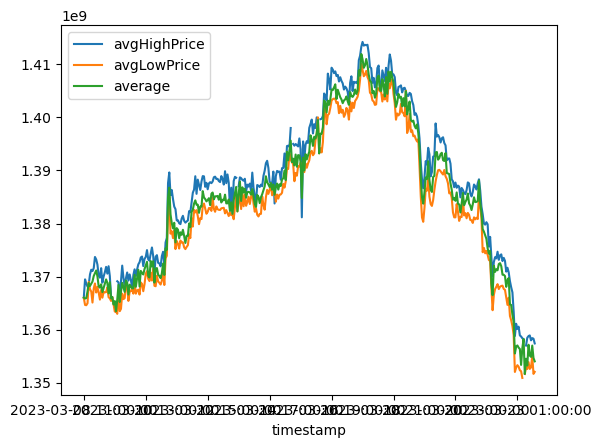

In [29]:

import pandas as pd
dt_pandas = pd.DataFrame(data)
# print(dt_pandas)
dt_pandas = dt_pandas.set_index('timestamp')
# dt_pandas.dropna(inplace=True)

# import matplotlib
dt_pandas = addAverage(dt_pandas)
dt_pandas.drop(columns=['lowPriceVolume', 'highPriceVolume'], inplace=True)
dt_pandas.plot()